In [2]:
чяёimport pandas as pd
import numpy as np
import uuid
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

## Задание 1.

In [3]:
df = pd.read_excel("transactions_data.xlsx", engine="openpyxl")

In [4]:
# посмотрим в каких столбцах есть пропуски
missing_values = df.isnull().sum()
missing_values

,0
transaction_id,474
client_id,202
transaction_date,0
service,0
amount,460
payment_method,0
city,0
consultant,0


In [5]:
dfmodel = df

Приведем даты к единому стандарту, а все неприводимые значения удалим, так же как и столбцы transaction_id и client_id

In [6]:
# для каждой строки приведем даты к единому стандарту, иначе удалим строку с неприводимыми данными
for index, row in df.iterrows():
  try:
    pd.to_datetime(df["transaction_date"][index], format='%Y-%m-%d %H:%M:%S')
  except:
    df = df.drop(index=index)

In [7]:
# для каждой строки приведем id к единому стандарту UUID, иначе удалим строку с неприводимыми данными
for index, row in df.iterrows():
  try:
    df.loc[index, "transaction_id"] = uuid.UUID(df["transaction_id"][index])
    df.loc[index, "client_id"] = uuid.UUID(df["client_id"][index])
  except:
    df = df.drop(index=index)

In [8]:
# аналогично приведем все строковые данные в строки, иначе удалим
for index, row in df.iterrows():
  try:
    df.loc[index, "service"] = str(df["service"][index])
    df.loc[index, "payment_method"] = str(df["payment_method"][index])
    df.loc[index, "city"] = str(df["city"][index])
    df.loc[index, "consultant"] = str(df["consultant"][index])
  except:
    df = df.drop(index=index)

Для обработки столбца amount заменим все некорректные значения и пропуски средним по столбцу.

In [9]:
# проверим есть ли в сырых данных нули в столбце amount
for index, row in df.iterrows():
  if df["amount"][index] == 0:
    print(1)

# для столбца amount заменим отрицательные значения на 0
for index, row in df.iterrows():
  if df["amount"][index] < 0:
    df.loc[index, "amount"] = 0

# вычислим среднее по столбцу amount
mean_df = df["amount"].mean()

# заменим все нули и пустые значения средним
for index, row in df.iterrows():
  if (df["amount"][index] == 0) or (pd.isna(df["amount"][index])) :
    df.loc[index, "amount"] = mean_df;

In [10]:
df

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena
5,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson
...,...,...,...,...,...,...,...,...
9994,c950f239-8404-43d1-ad3c-cf185483ac4f,602f63ba-3896-4462-8fb4-dd0921e5250b,2025-02-25 18:32:48,Инвестиционное консультирование,29445.814832,Неизвестно,New Dianechester,Catherine Lawson
9995,8c90fcca-6a86-4126-a645-62f0f00e09ff,b79d6e9f-75f6-4af9-8fdf-b42aac298a84,2025-01-14 05:07:17,Налоговое планирование,117114.096418,Неизвестно,South Thomas,John Wolfe
9997,03532e95-60c2-45ff-a731-3651d596989d,5e1d67fb-26ea-48cc-9e2d-e2edbda404d0,2025-02-09 17:33:42,Неизвестная услуга,79279.034410,Банковский перевод,Lake Arielmouth,Mary Howard
9998,f5df7e5e-5e5e-4492-afc7-98040ff89dde,77ea6e72-df3c-47d4-a043-f990cc05a6f4,2025-01-21 03:54:39,Инвестиционное консультирование,26365.015457,Криптовалюта,Tonystad,David Palmer


По итогам выполнения задания осталос 8394 строки

In [11]:
# проверим наличие повторяющихся строк
unique_counts = df.nunique()
unique_counts

,0
transaction_id,8394
client_id,8394
transaction_date,8386
service,6
amount,8013
payment_method,5
city,51
consultant,51


Повторяющиеся строки не найдены

## Задание 2.

In [12]:
# посчитаем количество строк с каждым уникальным значением в столбце
counts = df['service'].value_counts()
counts

,count
service,
Инвестиционное консультирование,2044
Управление активами,1685
Финансовое планирование,1312
Налоговое планирование,1274
Структурирование капитала,1251
Неизвестная услуга,828


Таким образом топ 5 услуг: Инвестиционное консультирование, Управление активами, Финансовое планирование, Налоговое планирование, Структурирование капитала. Все опознынне услуги вошли в топ.

In [13]:
# проходим по всем городам и считаем среднее по сумме транзакций для каждого города
for i in df["city"].unique():
  print("Средняя сумма транзакций по горду" , i  ,"=", df[df["city"] == i]["amount"].mean())


Средняя сумма транзакций по горду North Patrickport = 47236.420311674476
Средняя сумма транзакций по горду New Zacharyport = 53288.81664960534
Средняя сумма транзакций по горду Port Michellemouth = 57018.68602354266
Средняя сумма транзакций по горду Bondstad = 53071.14464368992
Средняя сумма транзакций по горду West Jaymouth = 46619.05245943714
Средняя сумма транзакций по горду Johnsonfort = 53084.74448024282
Средняя сумма транзакций по горду Tonystad = 48637.57931056868
Средняя сумма транзакций по горду Ronaldville = 50184.89007345775
Средняя сумма транзакций по горду Elizabethmouth = 43882.249104813556
Средняя сумма транзакций по горду Matthewsville = 45373.42194923123
Средняя сумма транзакций по горду North Lauriebury = 53811.76497738422
Средняя сумма транзакций по горду Lake Sallychester = 45649.972548483245
Средняя сумма транзакций по горду Trevinoberg = 53644.30372621783
Средняя сумма транзакций по горду South Andrew = 51169.93943449785
Средняя сумма транзакций по горду Hamiltont

In [14]:
# пройдемся по всем услугам и определим услугу с наибольшей выручкой, учитывая, что подходят только опознанные услуги
max = 0
name = "Структурирование капитала"
for i in df["service"].unique():
  mean = df[(df["service"] == i) & (i != "Неизвестная услуга")]["amount"].mean()
  if max <= mean:
    name = i
    max = mean
print("Услуга с наибольшей выручкой - это", name)

Услуга с наибольшей выручкой - это Инвестиционное консультирование


In [15]:
# проходим по всем способам оплаты и вычисляем процент использования по формуле: количество использований / всего транзакций * 100
sum1 = df['city'].count()
for i in df["payment_method"].unique():
  c = df[df["payment_method"] == i]["payment_method"].count()
  print("Процент транзакций с использованием", i, "=", c/sum1*100)

Процент транзакций с использованием Банковский перевод = 34.643793185608764
Процент транзакций с использованием Неизвестно = 10.078627591136526
Процент транзакций с использованием Кредитная карта = 40.04050512270669
Процент транзакций с использованием Криптовалюта = 5.2894924946390285
Процент транзакций с использованием Наличные = 9.947581605908983


In [16]:
# найдем дату последней транзакции и дату месяцем раньше нее, затем отфильтруем датафрейм по транзакциям за последний месяц и просуммируем выручку по этим транзакциям
max_date = df['transaction_date'].max()
last_month = max_date - relativedelta(months = 1)
last_amount = df[df['transaction_date'].between(last_month, max_date)]['amount'].sum()
print ("Суммарная выручка за последний месяц равна", last_amount)

Суммарная выручка за последний месяц равна 149329714.52233446


## Задание 3.

In [17]:
# считаем данные с json
cd = pd.read_json("clients_data.json")

In [18]:
# переименуем колонку для объединения
cd = cd.rename(columns={'id': 'client_id'})

In [19]:
# приведем колонку client_id у нового датафрейма в UUID формат
for index, row in cd.iterrows():
  try:
    cd.loc[index, "client_id"] = uuid.UUID(cd["client_id"][index])
  except:
    cd = cd.drop(index=index)

In [20]:
# объеденим датафреймы по client_id
mdf = pd.merge(df, cd,
                 on=['client_id'],
                 how='left')

In [21]:
missing_values_train = mdf.isnull().sum()
missing_values_train

,0
transaction_id,0
client_id,0
transaction_date,0
service,0
amount,0
payment_method,0
city,0
consultant,0
age,865
gender,2822


Пустые значения в net_worth можно заменить на среднее, в age можно удалить, а в gender можно заменить на неизвестно

In [22]:
# проверим наличие нулей и отрицательных значений в столбце net_worth
for index, row in mdf.iterrows():
  if (mdf["net_worth"][index] == 0) or (mdf["net_worth"][index] < 0):
    print(1)

In [23]:
mean = mdf["net_worth"].mean()
for index, row in mdf.iterrows():
  if  pd.isna(mdf["net_worth"][index]) :
    mdf.loc[index, "net_worth"] = mean
  if pd.isna(mdf["gender"][index]):
    mdf.loc[index, "gender"] = "Неизвестно"
  if pd.isna(mdf["age"][index]):
    mdf = mdf.drop(index=index)

In [24]:
mdf

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,age,gender,net_worth
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,41.0,Мужчина,2514729.46
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,28.0,Мужчина,566568.29
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,55.0,Женщина,1896001.28
3,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,31.0,Мужчина,4865849.92
4,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,59.0,Женщина,3992281.84
...,...,...,...,...,...,...,...,...,...,...,...
8389,c950f239-8404-43d1-ad3c-cf185483ac4f,602f63ba-3896-4462-8fb4-dd0921e5250b,2025-02-25 18:32:48,Инвестиционное консультирование,29445.814832,Неизвестно,New Dianechester,Catherine Lawson,43.0,Женщина,2549833.32
8390,8c90fcca-6a86-4126-a645-62f0f00e09ff,b79d6e9f-75f6-4af9-8fdf-b42aac298a84,2025-01-14 05:07:17,Налоговое планирование,117114.096418,Неизвестно,South Thomas,John Wolfe,33.0,Женщина,699254.80
8391,03532e95-60c2-45ff-a731-3651d596989d,5e1d67fb-26ea-48cc-9e2d-e2edbda404d0,2025-02-09 17:33:42,Неизвестная услуга,79279.034410,Банковский перевод,Lake Arielmouth,Mary Howard,49.0,Неизвестно,3865097.90
8392,f5df7e5e-5e5e-4492-afc7-98040ff89dde,77ea6e72-df3c-47d4-a043-f990cc05a6f4,2025-01-21 03:54:39,Инвестиционное консультирование,26365.015457,Криптовалюта,Tonystad,David Palmer,33.0,Женщина,4873134.42


В результате осталось 7529 строк

In [25]:
# запишем в новую колонку категории клиентов
for index, row in mdf.iterrows():
  if  mdf["net_worth"][index] < 100000 :
    mdf.loc[index, "level"] = "Низкий капитал"
  if  (mdf["net_worth"][index] >= 100000) and (mdf["net_worth"][index] <= 1000000) :
    mdf.loc[index, "level"] = "Средний капитал"
  if  mdf["net_worth"][index] > 1000000 :
    mdf.loc[index, "level"] = "Высокий капитал"

In [26]:
# пройдемся по всем уровням активов и посчитаем среднее выручки клиентов этой категории
m = 0
for i in mdf["level"].unique():
  m = mdf[mdf["level"] == i]["amount"].mean()
  print("Средняя выручка клинета категории", i, "=", m)

Средняя выручка клинета категории Высокий капитал = 49917.814831244636
Средняя выручка клинета категории Средний капитал = 49515.93438100639
Средняя выручка клинета категории Низкий капитал = 47430.810947166094


Таким образом клиенты с высоким капиталом приносят в среднем наибольшую выручку

## Задание 4.

Так как было много пропущенных значений, замененных на среднее, то исплючим из выборки для распределения заполенные средним строки

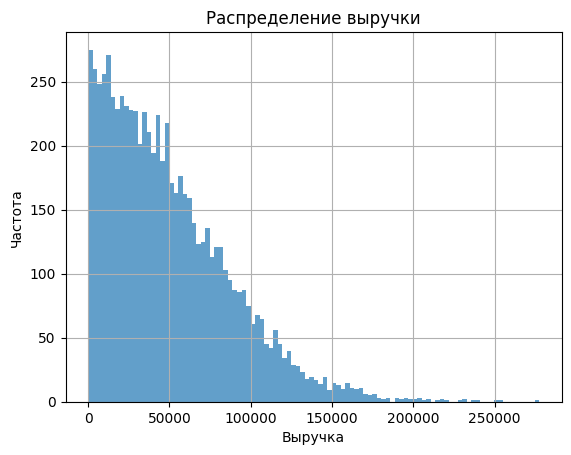

In [27]:
mdf[mdf["amount"] != mean_df]["amount"].plot.hist(bins=100, alpha=0.7)
plt.title("Распределение выручки")
plt.xlabel("Выручка")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

In [28]:
# построим диаграмму услуг по сумме выручки, для этого посчитаем суммы выруки для каждой услуги
grouped = mdf.groupby("service")["amount"].sum().reset_index()

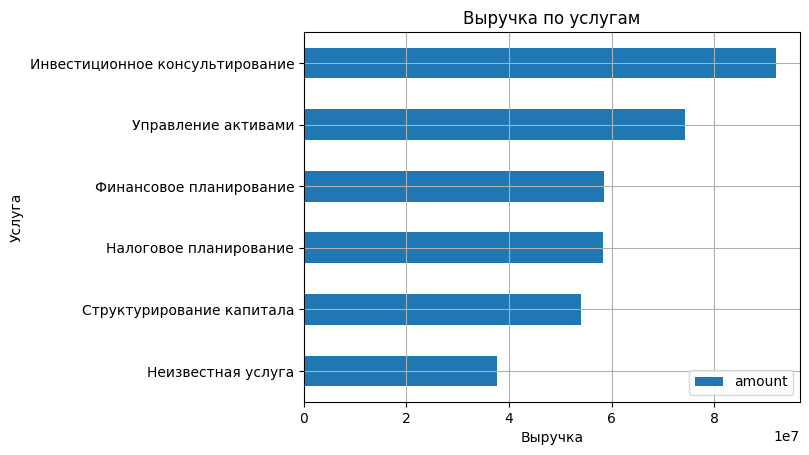

In [29]:
grouped.sort_values("amount").plot.barh(x="service", y="amount")
plt.title("Выручка по услугам")
plt.xlabel("Выручка")
plt.ylabel("Услуга")
plt.grid(True)
plt.show()

In [30]:
# аналогично отберем данные для графика
groupeda = mdf.groupby("age")["amount"].mean().reset_index()

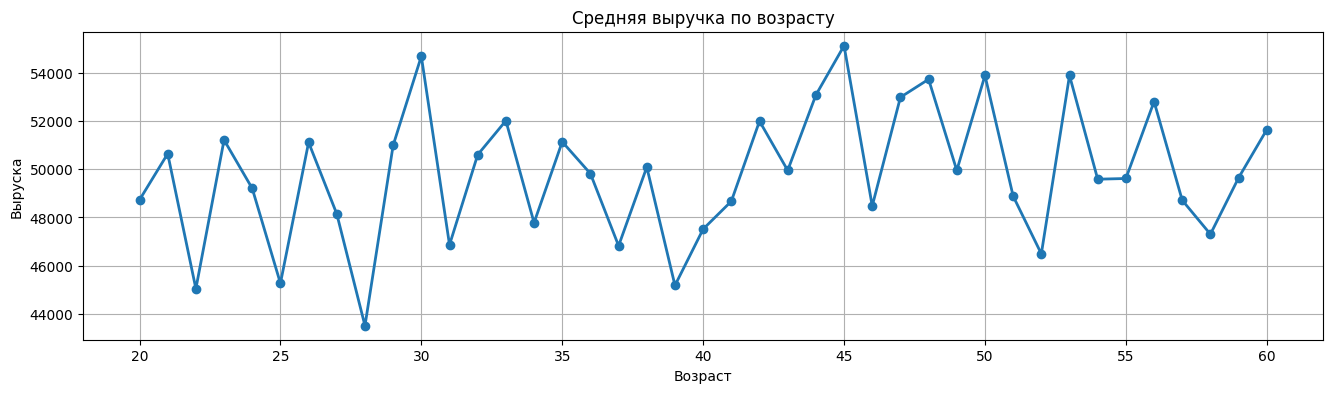

In [31]:
plt.figure(figsize=(16, 4))
plt.plot(groupeda["age"], groupeda["amount"], marker='o', linestyle='-', linewidth=2)
plt.title("Средняя выручка по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Выруска")
plt.grid(True)
plt.show()


## Задание 5.

Для начала обработаем данные. Так как никакие транзакции исключать нельзя, заменим все некорректные даты и пропущенные даты на равномерно распределенные по исследуемому периоду даты.

In [32]:
for index, row in dfmodel.iterrows():
  if dfmodel["amount"][index] == 0:
    print(1)

for index, row in dfmodel.iterrows():
  if dfmodel["amount"][index] < 0:
    dfmodel.loc[index, "amount"] = 0

mean_df = dfmodel["amount"].mean()

for index, row in dfmodel.iterrows():
  if (dfmodel["amount"][index] == 0) or (pd.isna(dfmodel["amount"][index])) :
    dfmodel.loc[index, "amount"] = mean_df;

In [33]:
dfmodel['transaction_date'] = pd.to_datetime(dfmodel['transaction_date'], errors='coerce')
for index, row in dfmodel.iterrows():
  if dfmodel['transaction_date'][index] == 'INVALID DATE':
    dfmodel.loc[index, 'transaction_date'] = np.nan
    dfmodel['amount'][index] = np.log1p(dfmodel['amount'][index])

inv_count = dfmodel['transaction_date'].isna().sum()

min_date = dfmodel['transaction_date'].min()
max_date = dfmodel['transaction_date'].max()


In [34]:
if inv_count > 0:
    new_dates = pd.date_range(start=min_date, end=max_date, periods=inv_count + 2)[1:-1]
    dfmodel.loc[dfmodel['transaction_date'].isna(), 'transaction_date'] = new_dates

Затем сгруппируем транзакции по датам, чтобы прогнозировать суммарную выручку на следующую дату по предыдущим. Так же заменим выручку на логарифм от выручки.

In [35]:
dfmodel['transaction_date'] = pd.to_datetime(dfmodel['transaction_date'])
daily1 = (dfmodel.groupby(dfmodel['transaction_date'].dt.date)['amount'].sum().rename_axis('date').reset_index())
daily1['date'] = pd.to_datetime(daily1['date'])

Добавим признаки для прогнозирования: выручки за предыдущие 3 дня и среднюю выручку за предыдущие 3

In [36]:
for i in range(1, 4):
  daily1['lag'+str(i)] = daily1['amount'].shift(i)
  daily1['lag^2'+str(i)] = daily1['amount'].shift(i)**2
  daily1['lag^3'+str(i)] = daily1['amount'].shift(i)**3
  daily1['lag^4'+str(i)] = daily1['amount'].shift(i)**4
  daily1['lag^5'+str(i)] = daily1['amount'].shift(i)**5
  daily1['lag^6'+str(i)] = daily1['amount'].shift(i)**6
  daily1['lag^7'+str(i)] = daily1['amount'].shift(i)**7
  daily1['lag^8'+str(i)] = daily1['amount'].shift(i)**8
  daily1['lag^9'+str(i)] = daily1['amount'].shift(i)**9

# daily1['day_of_week'] = daily1['date'].dt.dayofweek
# daily1['day_of_month'] = daily1['date'].dt.day
# for i in range(3, 6):
#     daily1['rolling' + str(i)] = daily1['amount'].shift(1).rolling(window=i).mean()

# daily1['growth'] = (daily1['lag1'] < daily1['lag2']).astype(int)

daily = daily1.dropna()

for column in daily1.columns:
  if column != 'date':
    daily[column] = np.log1p(daily[column])

daily

<ipython-input-36-3bda5a799e94>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily[column] = np.log1p(daily[column])


,date,amount,lag1,lag^21,lag^31,lag^41,lag^51,lag^61,lag^71,lag^81,...,lag^92,lag3,lag^23,lag^33,lag^43,lag^53,lag^63,lag^73,lag^83,lag^93
3,2025-01-04,15.780650,15.919557,31.839113,47.758670,63.678226,79.597783,95.517339,111.436896,127.356453,...,141.222431,15.628481,31.256962,46.885443,62.513924,78.142405,93.770886,109.399367,125.027848,140.656329
4,2025-01-05,15.672393,15.780650,31.561301,47.341951,63.122601,78.903252,94.683902,110.464552,126.245203,...,143.276009,15.691381,31.382763,47.074144,62.765525,78.456906,94.148288,109.839669,125.531050,141.222431
5,2025-01-06,15.732376,15.672393,31.344786,47.017179,62.689572,78.361965,94.034358,109.706751,125.379145,...,142.025853,15.919557,31.839113,47.758670,63.678226,79.597783,95.517339,111.436896,127.356453,143.276009
6,2025-01-07,15.604461,15.732376,31.464752,47.197129,62.929505,78.661881,94.394257,110.126633,125.859010,...,141.051538,15.780650,31.561301,47.341951,63.122601,78.903252,94.683902,110.464552,126.245203,142.025853
7,2025-01-08,15.623708,15.604461,31.208921,46.813382,62.417842,78.022303,93.626764,109.231224,124.835685,...,141.591386,15.672393,31.344786,47.017179,62.689572,78.361965,94.034358,109.706751,125.379145,141.051538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,2025-03-16,15.507711,15.605791,31.211583,46.817374,62.423165,78.028956,93.634748,109.240539,124.846330,...,140.783427,15.766892,31.533784,47.300676,63.067568,78.834460,94.601352,110.368245,126.135137,141.902029
75,2025-03-17,15.675804,15.507711,31.015422,46.523134,62.030845,77.538556,93.046267,108.553979,124.061690,...,140.452122,15.642603,31.285206,46.927809,62.570412,78.213015,93.855618,109.498221,125.140824,140.783427
76,2025-03-18,15.723441,15.675804,31.351609,47.027413,62.703217,78.379021,94.054826,109.730630,125.406434,...,139.569401,15.605791,31.211583,46.817374,62.423165,78.028956,93.634748,109.240539,124.846330,140.452122
77,2025-03-19,15.617469,15.723441,31.446881,47.170321,62.893762,78.617202,94.340643,110.064083,125.787524,...,141.082239,15.507711,31.015422,46.523134,62.030845,77.538556,93.046267,108.553979,124.061690,139.569401


Формируем данные для моделей, а так же набор количества последних дней для теста

In [37]:
X = daily.drop(columns=['amount', 'date'])
y = daily['amount']

train_idx = 7

Пробуем несколько моделей для предсказания выручки, оцениваем по среднему MAPE и R2

In [38]:
candidates = {
    'lin'   : LinearRegression(),
    'ridge' : Ridge(alpha=10.0),
    'rf': RandomForestRegressor(n_estimators=100,
                                max_depth=6,
                                min_samples_split=4,
                                min_samples_leaf=1,
                                random_state=42,
                                n_jobs=-1,
                                max_features='log2'),
    'gbr': GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=3,
        min_samples_split=4,
        min_samples_leaf=4,
        subsample=0.8,
        random_state=42
    ),
    'xgb': XGBRegressor(
        n_estimators=500,
        learning_rate=0.02,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=2,
        reg_alpha=0.5,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ),
    'svr'  : SVR(C=5, epsilon=0.2, kernel='rbf'),
    'etr'  : ExtraTreesRegressor(
                 n_estimators=400, max_depth=6,
                 min_samples_leaf=2, random_state=42, n_jobs=-1, min_samples_split  = 4),
    'ada'  : AdaBoostRegressor(
                 n_estimators=400, learning_rate=0.03, random_state=42),
    'cat'  : CatBoostRegressor(
                 iterations=400, learning_rate=0.03,
                 depth=4, l2_leaf_reg=3,
                 loss_function='MAE', random_state=42,
                 verbose=False),
}
for name, mdl in candidates.items():
  r2 = 0
  mape = 0
  l =len(X)
  test_start = l
  test_end = l
  for i in range(1,4):
    test_start = l - train_idx * i
    test_end = l - train_idx * (i-1)
    train = test_start
    X_train, y_train = X.iloc[:train], y.iloc[:train]
    X_test,  y_test  = X.iloc[test_start:test_end], y.iloc[test_start:test_end]
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    y_test = np.expm1(y_test)
    y_pred = np.expm1(y_pred)
    mape += mean_absolute_percentage_error(y_test, y_pred)
    r2  += r2_score(y_test, y_pred)

  print(name, "MAPE =", mape/3, "; R2 =", r2/3)

lin MAPE = 0.12240422664017503 ; R2 = -0.29335802222519664
ridge MAPE = 0.12410672589021617 ; R2 = -0.3520749177348171
rf MAPE = 0.11457045024682026 ; R2 = -0.08784797305299057
gbr MAPE = 0.11770938243602776 ; R2 = -0.14417028563424839
xgb MAPE = 0.11996382499471757 ; R2 = -0.23093046490890726
svr MAPE = 0.122121830231419 ; R2 = -0.3044440875928478
etr MAPE = 0.11118832108273317 ; R2 = 0.08615488931353965
ada MAPE = 0.11742176966855294 ; R2 = -0.10000856650438102
cat MAPE = 0.11973688188087737 ; R2 = -0.17901520253013634


В результате получилось, что наилучший результат дает случайный лес

Далее подбираем оптимальные параметры для случайного леса

In [39]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [4, 6, 8],
    'min_samples_split': [1, 2, 4, 6],
    'min_samples_leaf': [1, 2, 3, 4],
}

scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

etr = ExtraTreesRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(estimator=etr,
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X, y)


Fitting 5 folds for each of 192 candidates, totalling 960 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
240 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 4, 6],
                         'n_estimators': [100, 200, 300, 400]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False, response_method='predict'),
             verbose=2)

In [40]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка:", -grid_search.best_score_)

Лучшие параметры: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}
Лучшая оценка: 0.006043360847374847


Задаем параметры модели для предсказания

In [41]:
last_date   = daily['date'].max()
start_next  = last_date + pd.Timedelta(days=1)
end_next    = (last_date + relativedelta(months = 1)) - pd.Timedelta(days=1)
X_train, y_train = X.iloc[:], y.iloc[:]
model = ExtraTreesRegressor(
                 n_estimators=400, max_depth=6,
                 min_samples_leaf=2, random_state=42, n_jobs=-1, min_samples_split  = 4)
model.fit(X_train, y_train)

future_dates = pd.DataFrame({'date': pd.date_range(start_next, end_next, freq='D')})

Для того, чтобы использовать данные о предыдущий предсказанных днях, их необходимо запоминать. Далее запускаем для каждого последующего дня прогнозирование выручки в течении месяца (30 дней)

In [42]:
history = daily.copy()

preds = []

for current_date in future_dates['date']:
    row = {'date': current_date}

    for i in range (1, 4):
      lag_date = current_date - pd.Timedelta(days=i)
      lag = history.loc[history['date'] == lag_date, 'amount']
      row['lag'+str(i)] = lag.values[0]
      row['lag^2'+str(i)] = lag.values[0]*2
      row['lag^3'+str(i)] = lag.values[0]*3
      row['lag^4'+str(i)] = lag.values[0]*4
      row['lag^5'+str(i)] = lag.values[0]*5
      row['lag^6'+str(i)] = lag.values[0]*6
      row['lag^7'+str(i)] = lag.values[0]*7
      row['lag^8'+str(i)] = lag.values[0]*8
      row['lag^9'+str(i)] = lag.values[0]*9
    # for i in range (3, 4):
    #   last_days = history.loc[(history['date'] < current_date) & (history['date'] >= current_date - pd.Timedelta(days=i)), 'amount']
    #   row['rolling'+str(i)] = last_days.mean()

    # row['growth'] = int(row['lag1'] < row['lag2'])

    X_pred = pd.DataFrame([row])
    X_pred = X_pred.drop(columns=['date'])

    X_pred = X_pred.fillna(0)

    pred_amount = model.predict(X_pred)[0]
    preds.append({'date': current_date, 'amount': pred_amount})

    new_row = row.copy()
    new_row['amount'] = pred_amount
    history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)


Считаем предсказанную сумму RandomForest

In [43]:
sum = 0
for p in preds:
  p['amount'] = np.expm1(p['amount'])
  sum+=p['amount']

In [44]:
print(f'Предсказанная сумма выручки за следующий месяц =', sum)

Предсказанная сумма выручки за следующий месяц = 184611499.63627392
